# Initial learning trials
functional: b3lypg

basis: sto-3g

In [12]:
import numpy as np
from glob import glob
import os, sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

train_test_seed = 42

source_path = '../../datasets/QM9/xyz_c5h4n2o2/'
all_file_paths = glob(os.path.join(source_path, '*.xyz'))
len(all_file_paths)

509

In [13]:
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap

check if all files converged - if we have something to compare to!

In [14]:
focks = []
used_files = []
reference_densities = []
for file in all_file_paths:
    mol_name = os.path.basename(file).split(".")[0]
    # print(mol_name)
    ret = density_fock_overlap(filepath = file,
                         filename = mol_name,
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = "../../datasets/QM9/out/c5h4n2o2-sto-3g-b3lyp")
    if any([r == None for r in ret]): 
        print(f"File {mol_name} bad - skipping")
        continue
    focks.append(ret[1].numpy)
    used_files.append(file)
    reference_densities.append(ret[0].numpy)
print(f"Using {len(focks)} files from {len(all_file_paths)} total files")

File dsgdb9nsd_057125 bad - skipping
Using 508 files from 509 total files


Now let's create the reference - use the overlap matrix - this is already needed for the first step so this is basically free! 

In [15]:
from scf_guess_tools import Backend, load
from pyscf.gto import Mole
import re, time
import matplotlib.pyplot as plt

overlaps = []
for file in used_files:
    lines = open(file).readlines()
    q = int(re.search(r"charge\s+(-?\d+)", lines[1]).group(1))
    m = int(re.search(r"multiplicity\s+(\d+)", lines[1]).group(1))
    start_ = time.time()
    mol = Mole(atom=file, charge=q, spin=m - 1, symmetry=True)
    mol.basis = 'sto-3g'
    mol.build()
    S = mol.intor('int1e_ovlp')
    overlaps.append(np.asarray(S))

Now we have our in & outputs but half of the matrix is irrelevant so we use the following utility functions

In [16]:
def flatten_triang(M): 
    return M[np.triu_indices(M.shape[0], k=0)]
def unflatten_triang(flat, N):
    M = np.zeros((N, N))
    iu = np.triu_indices(N)
    M[iu] = flat
    M[(iu[1], iu[0])] = flat  # Symmetrie
    return M

## Dataset split

In [17]:
train, test = train_test_split(
    list(zip(focks, overlaps, used_files)), 
    test_size=0.2, 
    random_state=train_test_seed
)

### Now Ridge Regression

In [18]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor
import pickle
model_path = "models/simple_ridge_model.pkl"

In [19]:
X = np.array([flatten_triang(overlap) for _, overlap, _ in train])
y = np.array([flatten_triang(fock) for fock, _ , _ in train])
if os.path.exists(model_path):
    print("Loading model from disk...")
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
else:
    # Train the model
    print("Training model...")
    # Flatten the matrices and train the model
    base_model = RidgeCV(alphas=np.logspace(-1.5, 2.5, 5, base=10), cv=5)
    model = MultiOutputRegressor(base_model)
    start_ = time.time()
    model.fit(X,y=y)
    print(f"CV Training time: {time.time() - start_:.2f} seconds")
    best_alphas = np.array([estimator.alpha_ for estimator in model.estimators_])
    print(f"Best alphas: \nmean: {best_alphas.mean()}\nstd: {best_alphas.std()}\nmin: {best_alphas.min()}\nmax: {best_alphas.max()}")
    base_model = Ridge(alpha=best_alphas.mean())
    model = MultiOutputRegressor(base_model)

    start_ = time.time()
    model.fit(X, y=y)
    print(f"Refit-Training time: {time.time() - start_:.2f} seconds")
    
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)


train_pred = model.predict(X)
train_error = root_mean_squared_error(y, train_pred)
print(f"Train error: {train_error:.4f}")

# test error:
X_test = np.array([flatten_triang(overlap) for _ , overlap, _ in test])
y_test = np.array([flatten_triang(fock) for fock, _, _  in test])
test_pred = model.predict(X_test)
test_error = root_mean_squared_error(y_test, test_pred)
print(f"Test error: {test_error:.4f}")
sum_of_squares = np.mean(np.sum((np.zeros_like(y_test) - y_test)**2, axis=1))
print(f"Average sum of squares of y_test: {sum_of_squares:.4f}")

Loading model from disk...
Train error: 0.0436
Test error: 0.0570
Average sum of squares of y_test: 1801.2192


ok sum of squares is really large compared to RMSE and RMSE between train and test is comparable but certainly not good -> I mean we have a small dataset only 508 samples!

In [20]:
def plot_fock_comparison(ex_test, ex_pred, size, matrix_metric="Fock", title="Fock Matrix Comparison", vmax=1.5):
    diff = ex_test - ex_pred
    rmse = root_mean_squared_error(ex_test, ex_pred)
    
    test_mat = unflatten_triang(ex_test, size) if ex_test.shape[0] != size else ex_test
    pred_mat = unflatten_triang(ex_pred, size) if ex_pred.shape[0] != size else ex_pred
    diff_mat = unflatten_triang(diff, size) if diff.shape[0] != size else diff
    
    fig, ax = plt.subplots(1, 4, figsize=(15, 5), width_ratios=[1, 1, 1, 0.1])
    fig.suptitle(f"{title}  |  RMSE: {rmse:.8f}")
    
    ax[0].imshow(test_mat, cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax[0].set_title(f"{matrix_metric} converged (REFERENCE)")
    
    ax[1].imshow(pred_mat, cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax[1].set_title(f"{matrix_metric} from overlap (PREDICTION)")
    
    diff_plot = ax[2].imshow(diff_mat, cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax[2].set_title("Difference")
    
    cbar = fig.colorbar(diff_plot, cax=ax[3])
    cbar.set_label("Difference Scale")
    
    plt.tight_layout()
    plt.show()

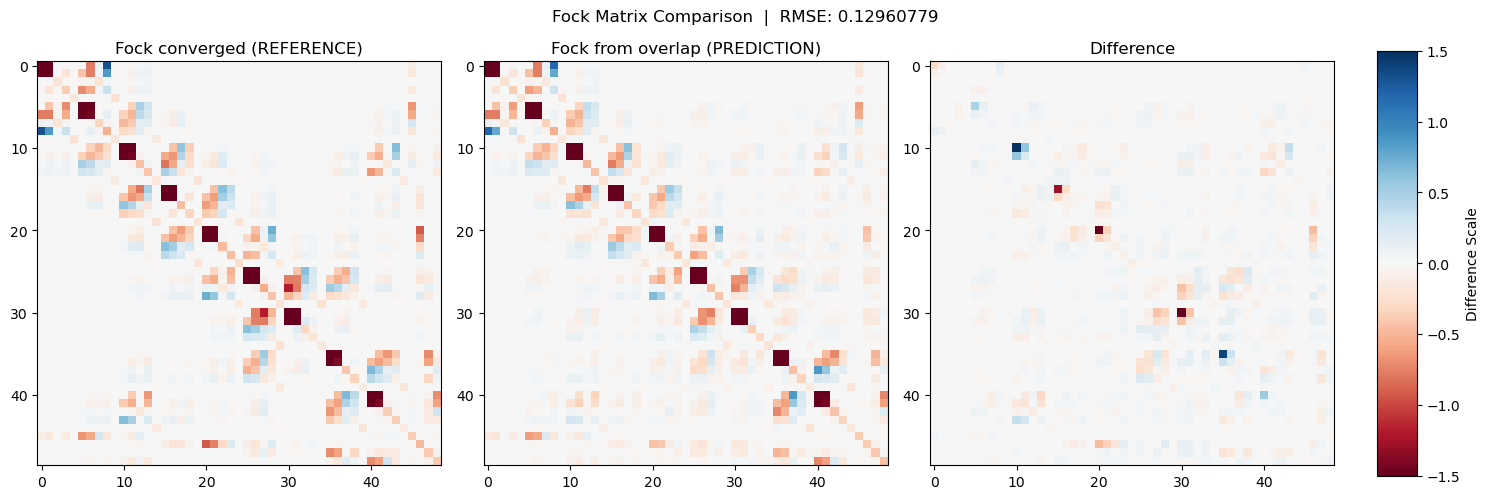

In [21]:
# let's checkout a example: 
random_test_sample = np.random.randint(0, len(X_test))
ex_test = y_test[random_test_sample]
ex_pred = test_pred[random_test_sample]

# diff = ex_test - ex_pred
# diff = unflatten_triang(diff, 49)
# rmse = root_mean_squared_error(ex_test, ex_pred)
# print(f"RMSE: {rmse:.4f}")
# fig, ax = plt.subplots(1, 4, figsize=(15, 5), width_ratios=[1, 1, 1, 0.1])
# fig.suptitle(f"RMSE: {rmse:.4f}")
# ax[0].imshow(unflatten_triang(ex_test, 49), cmap='RdBu', vmin=-1.5, vmax=1.5)
# ax[0].set_title("Fock converged (REFERENCE)")
# ax[1].imshow(unflatten_triang(ex_pred, 49), cmap='RdBu', vmin=-1.5, vmax=1.5)
# ax[1].set_title("Fock from overlap (PREDICTION)")
# diff_plot = ax[2].imshow(diff, cmap='RdBu', vmin=-1.5, vmax=1.5)
# ax[2].set_title("Difference")
# cbar = fig.colorbar(diff_plot, cax=ax[3])
# cbar.set_label("Difference Scale")
plot_fock_comparison(ex_test, ex_pred, 49, title="Fock Matrix Comparison", vmax=1.5)

# Check if convergence is faster! 

In [22]:
from scipy.linalg import eigh
def check_positive_definite(S, tol=1e-10):
    # Eigenwerte prüfen
    eigvals = np.linalg.eigvalsh(S)
    is_pd = np.all(eigvals > tol)
    return is_pd

def density_pred(model, overlap, nocc): 
    assert check_positive_definite(overlap)
    fock = model.predict(flatten_triang(overlap).reshape(1, -1))
    fock = unflatten_triang(fock, overlap.shape[0])
    _, C = eigh(fock, overlap)
    C_occ = C[:, :nocc]
    density = C_occ @ C_occ.T # *2 because of spin degeneracy
    return density

def comp_trace(overlap, *args): 
    for arg in args: 
        trace_ = np.trace(arg @ overlap)
        print(f"Trace: {trace_}")
    

In [23]:
from scf_guess_tools import Backend, guess, calculate, load
from pyscf import scf

def sim(file, overlap, use_pred=False): 
    backend = Backend.PY
    mol = load(file, backend)
    mol_native = mol.native
    mol_native.basis = "sto-3g"
    mol_native.build()

    if use_pred: 
        start_ = time.time()
        D_ = density_pred(model, overlap, mol_native.nelec[0]) # nocc per shell
        mf = scf.RKS(mol_native)
        mf.xc = "b3lypg"
        print(f"Pred time, {time.time() - start_}")
        mf.kernel(dm0=D_)
        wf = mf
        
    else: 
        wf = calculate(mol, basis="sto-3g", method="dft", functional="b3lypg", guess="1e", cache=False)
        wf = wf.native

    return {"cycles": wf.cycles, "conv": wf.converged, "summary": wf.scf_summary}


In [39]:
reference_time, model_time = [], []
iterations = []
early_stop = 25
for _, overlap, file in test: # benchmark on test data! 
    print(f"File: {file}")
    start_ = time.time()
    res_ref = sim(file, overlap)
    print(res_ref)
    end_ = time.time()
    # print(f"Reference time: {end_ - start_:.2f} seconds")
    reference_time.append(end_ - start_)
    start_ = time.time()
    res = sim(file, overlap, use_pred=True)
    print(res)
    end_ = time.time()
    # print(f"Guess time: {end_ - start_:.2f} seconds")
    model_time.append(end_ - start_)
    iterations.append((res_ref["cycles"], res["cycles"]))
    if early_stop < 0: 
        break
    early_stop -= 1


File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_028121.xyz
converged SCF energy = -446.946703790827
{'cycles': 25, 'conv': True, 'summary': {'nuc': np.float64(433.8378878463838), 'e1': np.float64(-1469.2974777414397), 'coul': np.float64(648.1255886407039), 'exc': np.float64(-59.61270253647531)}}
Pred time, 0.20848584175109863
converged SCF energy = -446.946703900747
{'cycles': 18, 'conv': True, 'summary': {'nuc': np.float64(433.8378878463838), 'e1': np.float64(-1469.2975161330996), 'coul': np.float64(648.1256288311068), 'exc': np.float64(-59.61270444513771)}}
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_131581.xyz
SCF not converged.
SCF energy = -366.318714888427
{'cycles': 50, 'conv': False, 'summary': {'nuc': np.float64(380.1825821149959), 'e1': np.float64(-1308.9646695798492), 'coul': np.float64(624.5208153219667), 'exc': np.float64(-62.05744274554084)}}
Pred time, 0.23195743560791016
converged SCF energy = -446.816879400946
{'cycles': 19, 'conv': True, 'summary': {'nuc': np.floa

Not converged reference: 10
Not converged model: 0
Reference iterations: 24+/-4
Model iterations: 19.6+/-2.8
Reference time: 6.9+/-1.0
Model time: 6.0+/-0.8
Speedup: 1.15+/-0.23x


/tmp/ipykernel_38450/2089869450.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([reference_time_c, model_time_c], labels=["Reference", "Model"], patch_artist=True)


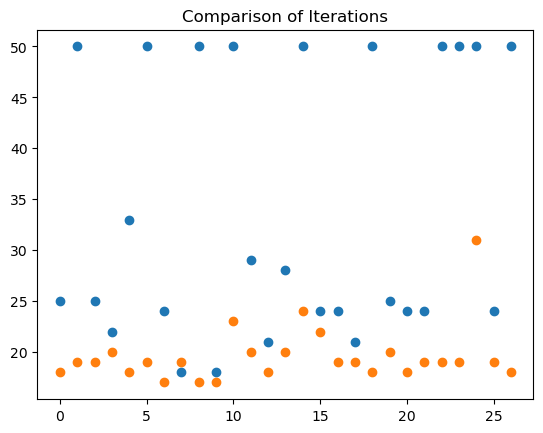

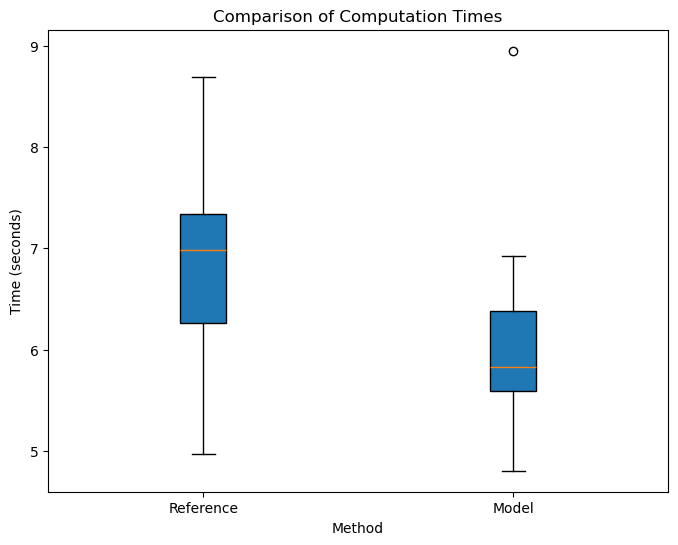

In [40]:
import uncertainties as unc
reference_it = [it[0] for it in iterations]
model_it = [it[1] for it in iterations]
reference_time_c = [time for time in reference_time]
model_time_c = [time for time in model_time]
plt.scatter(np.arange(len(reference_it)), reference_it, label="Reference")
plt.scatter(np.arange(len(reference_it)), model_it, label="Model")
plt.title("Comparison of Iterations")
print(f"Not converged reference: {len([it for it in reference_it if it == 50])}")
print(f"Not converged model: {len([it for it in model_it if it == 50])}")

converged_ind = np.where(np.array(reference_it) != 50)[0]
converged_ind_model = np.where(np.array(model_it) != 50)[0]
reference_it = np.array(reference_it)[converged_ind]
model_it = np.array(model_it)[converged_ind_model]
reference_time_c = np.array(reference_time_c)[converged_ind]
model_time_c = np.array(model_time_c)[converged_ind_model]


it = unc.ufloat(np.mean(reference_it), np.std(reference_it))
it_model = unc.ufloat(np.mean(model_it), np.std(model_it))
print(f"Reference iterations: {it}")
print(f"Model iterations: {it_model}")
time_ref = unc.ufloat(np.mean(reference_time_c), np.std(reference_time_c))
time_model = unc.ufloat(np.mean(model_time_c), np.std(model_time_c))
print(f"Reference time: {time_ref}")
print(f"Model time: {time_model}")
print(f"Speedup: {time_ref / time_model:.2f}x")

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([reference_time_c, model_time_c], labels=["Reference", "Model"], patch_artist=True)
ax.set_title("Comparison of Computation Times")
ax.set_ylabel("Time (seconds)")
ax.set_xlabel("Method")
plt.show()


Hmm funktioniert doch nicht einmal so gut

In [120]:
sample_file = used_files[0]
mol = load(sample_file, Backend.PY)
nr_elec = mol.native.nelec[0]
ref_density = reference_densities[0]
guess_density = density_pred(model, overlaps[0], nr_elec)
comp_trace(overlaps[0], ref_density, guess_density)

Trace: 32.00000310499718
Trace: 32.000000000000014


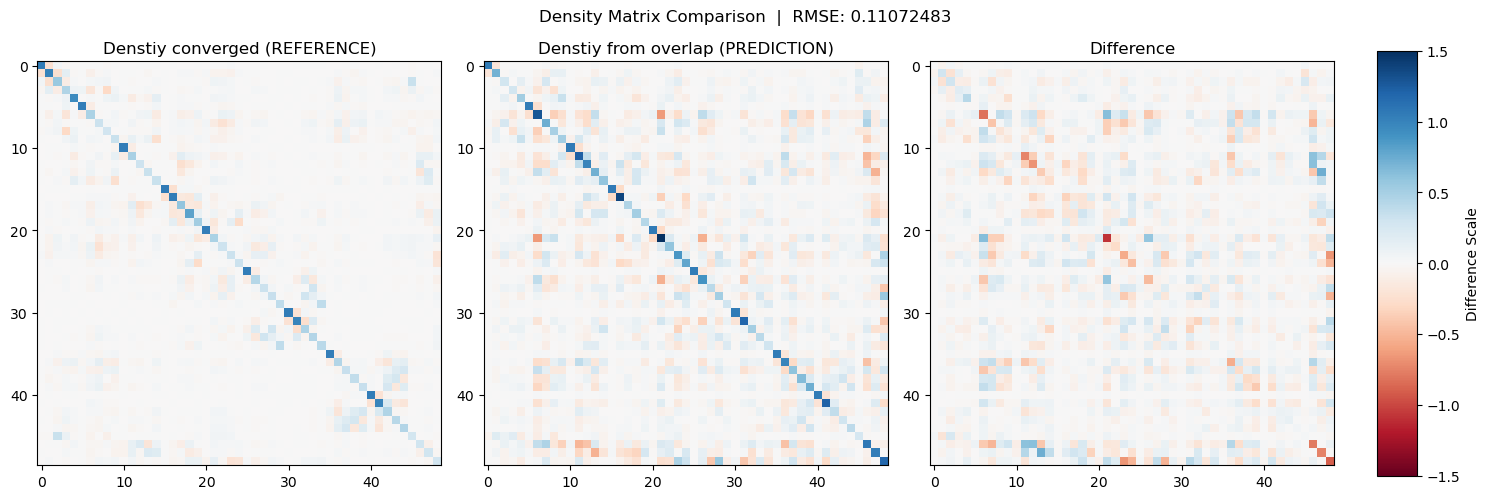

In [121]:
plot_fock_comparison(ref_density, guess_density, 49, matrix_metric="Denstiy", title="Density Matrix Comparison", vmax=1.5)

Ok - reference Fock --> Density mit Ref Density vergleichen - die sollten exakt gleich sein

In [83]:
def density_from_fock(fock, overlap, nocc): 
    _, C = eigh(fock, overlap)
    C_occ = C[:, :nocc]
    density = C_occ @ C_occ.T
    return density

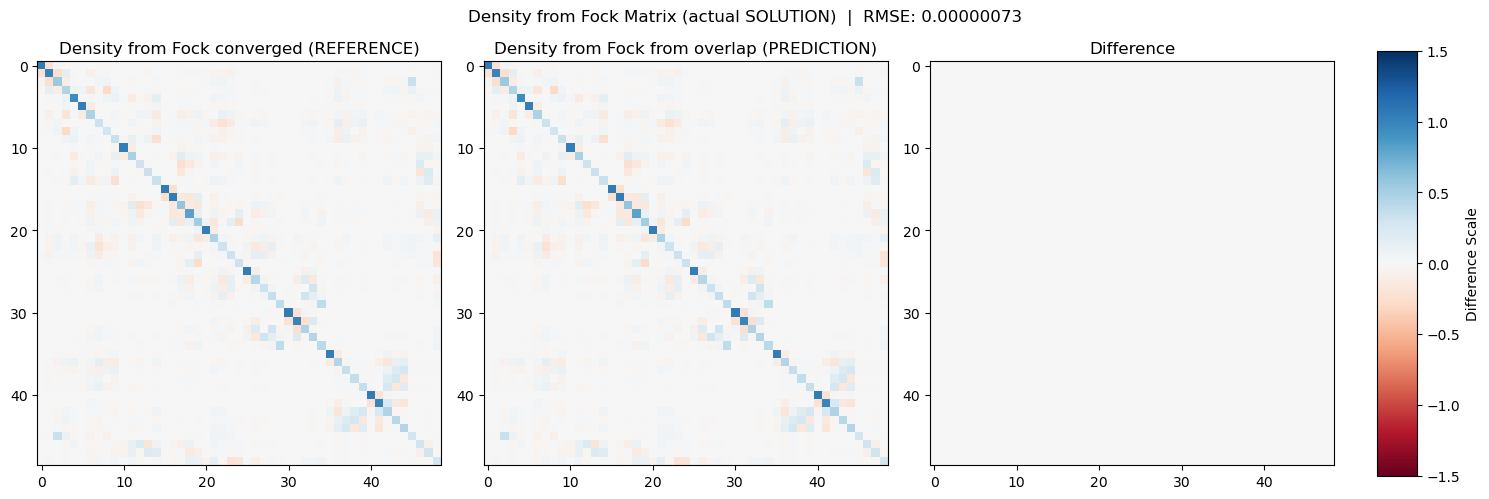

In [84]:
ref_fock = focks[0]
density_from_fock = density_from_fock(ref_fock, overlaps[0], nr_elec)
plot_fock_comparison(ref_density, density_from_fock, 49, matrix_metric="Density from Fock", title="Density from Fock Matrix (actual SOLUTION)", vmax=1.5)

Ok es funktioniert also, wenn die Fock-Matrix wohl sehr ähnlich ist! Noch ein Sanity check ob auch die iterationen gegen 1 gehen: 

converged SCF energy = -446.946703900964
Took: 11 cycles: 3.68 seconds
Loaded mol from ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_028121.xyz
converged SCF energy = -446.946703900964
Sum of squares density new calc: 26.8880 - nr elec: 32.0
Sum of squares density scf: 107.5519 - nr elec: 63.99999999999996


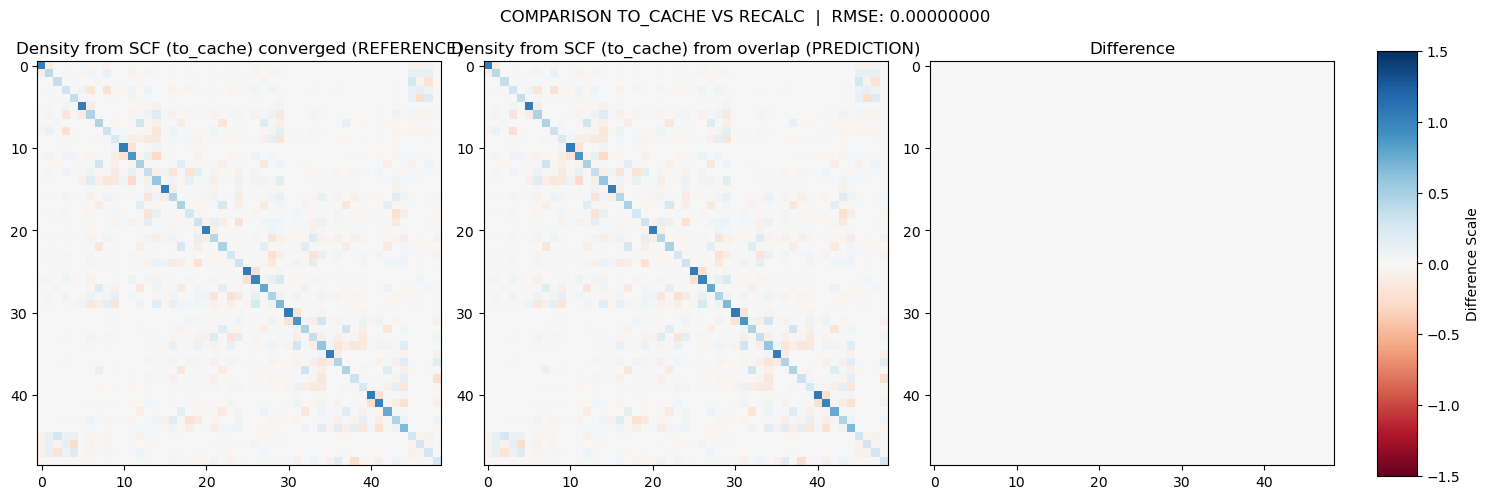

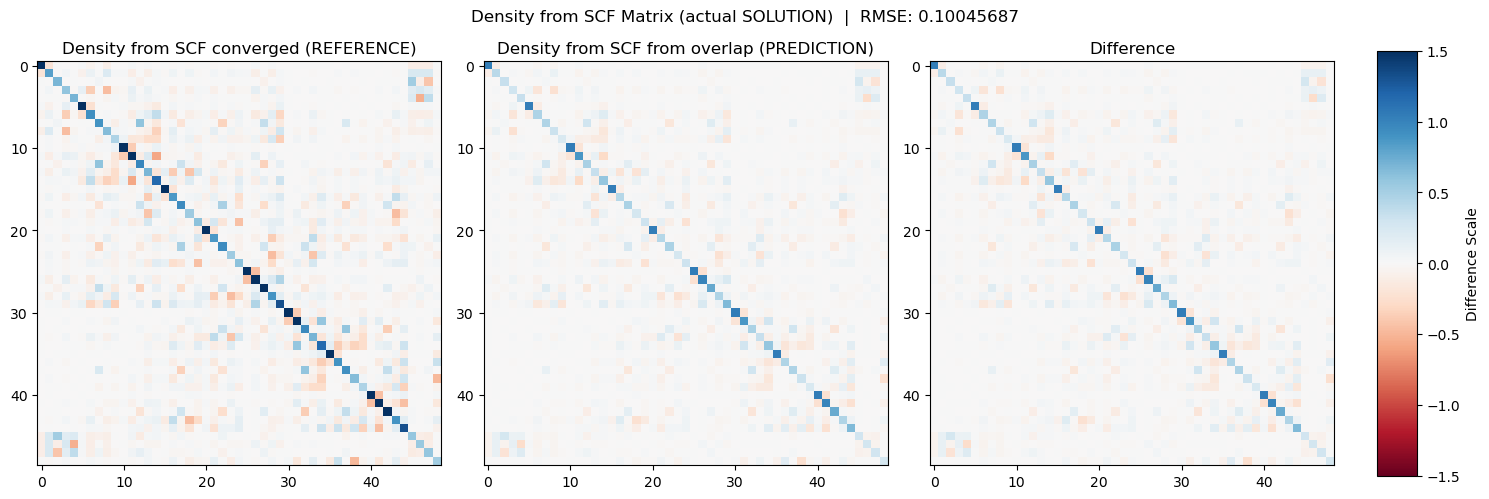

In [97]:
start_ = time.time()
file = test[0][2]
mol = load(file, Backend.PY).native
mol.basis = "sto-3g"
mol.build()

mf = scf.RKS(mol)
mf.xc = "b3lypg"
mf.kernel()
print(f"Took: {mf.cycles} cycles: {time.time() - start_:.2f} seconds")
density_matrix_scf = mf.make_rdm1()
overlap = mol.intor('int1e_ovlp')


ret = density_fock_overlap(filepath = file,
                         filename = os.path.basename(file).split(".")[0],
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = "../../datasets/QM9/out/c5h4n2o2-sto-3g-b3lyp")

ret_new = density_fock_overlap(filepath = file,
                         filename = os.path.basename(file).split(".")[0],
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = False)
reference_density = ret[0].numpy
ref_overlap = ret_new[2].numpy
density_matrix_new_calc = ret_new[0].numpy


sum_of_squares_density_new_calc = np.sum(density_matrix_new_calc**2)
sum_of_squares_density_scf = np.sum(density_matrix_scf**2)
nr_elec_scf = np.trace(density_matrix_scf @ overlap)
nr_elec_new_calc = np.trace(density_matrix_new_calc @ ref_overlap)
print(f"Sum of squares density new calc: {sum_of_squares_density_new_calc:.4f} - nr elec: {nr_elec_new_calc}")
print(f"Sum of squares density scf: {sum_of_squares_density_scf:.4f} - nr elec: {nr_elec_scf}")
# plot_fock_comparison(density_matrix_new_calc, reference_density, 49, matrix_metric="Density from SCF (to_cache)", title="COMPARISON TO_CACHE VS RECALC", vmax=1.5)
plot_fock_comparison(density_matrix_scf, reference_density, 49, matrix_metric="Density from SCF", title="COMPARISON TO_CACHE VS RECALC", vmax=1.5)

Wo ist der unterschied zwischen meinem to_cache wrapper und default pyscf?

In [101]:
file = test[0][2]
print(f"File: {file}")
to_cache_ret = density_fock_overlap(filepath = file,
                         filename = os.path.basename(file).split(".")[0],
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = False)
density_matrix_new_calc = to_cache_ret[0].numpy
overlap = to_cache_ret[2].numpy
print(f"Trace: {np.trace(density_matrix_new_calc @ overlap):.4f}")

File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_028121.xyz
Loaded mol from ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_028121.xyz
converged SCF energy = -446.946703900965
Trace: 32.0000


In [102]:
mol = Mole(atom=file, charge=0, spin=0, symmetry=False)
mol.basis = 'sto-3g'
mol.build()

mf = scf.RKS(mol)
mf.xc = "b3lypg"
mf.kernel()
mf.cycles
print(f"Took: {mf.cycles} cycles")
density_matrix_scf = mf.make_rdm1()
overlap = mol.intor('int1e_ovlp')
print(f"Trace: {np.trace(density_matrix_scf @ overlap):.4f}")

converged SCF energy = -446.946703170138
Took: 11 cycles
Trace: 64.0000


Trace ok -> is it a factor of 2? -> Yes actually Yes!!! --> so this looks quite ok! 

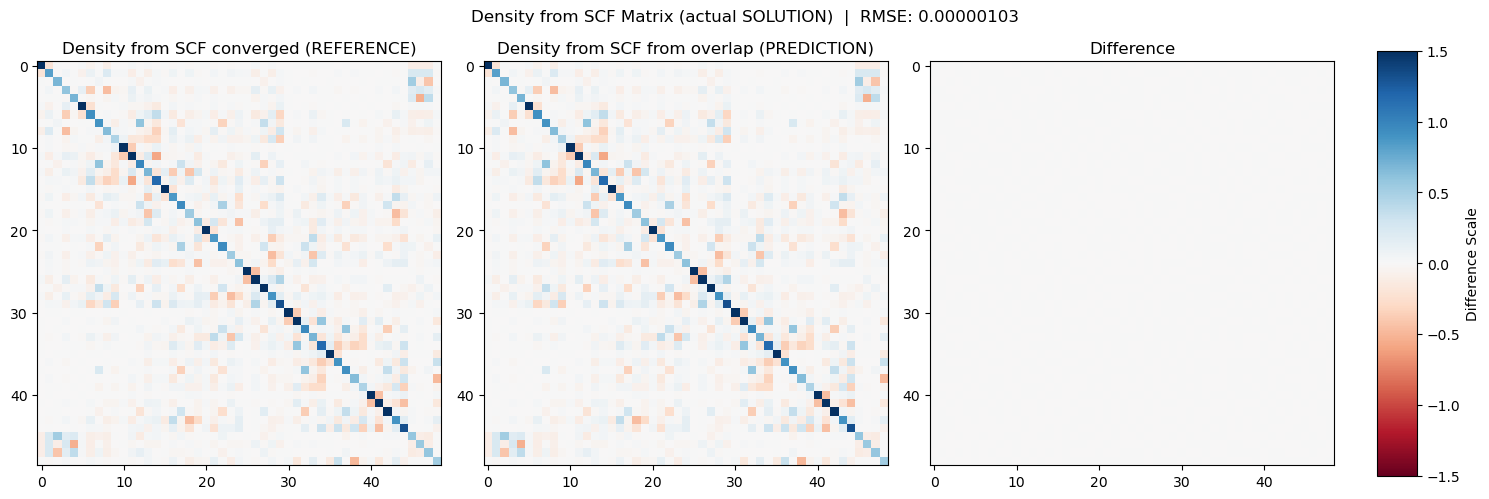

In [105]:
plot_fock_comparison(2*density_matrix_new_calc, density_matrix_scf, 49, matrix_metric="Density from SCF", title="Density from SCF Matrix (actual SOLUTION)", vmax=1.5)